# Name: Archishman Biswas
# Roll no. 180070009
# EE 679: Computation Assignment 3: ASR
 

# Code for connecting to drive folder (ignore/do not run if not on google colab)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
import os 
root_dir = "/content/gdrive/MyDrive/EE 679 Speech Processing Assignments/"
project_folder = "3"

def create_and_set_working_directory(project_folder):
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')
  os.chdir(root_dir + project_folder)
  
create_and_set_working_directory(project_folder)
! pwd

Mounted at /content/gdrive/
/content/gdrive/MyDrive/EE 679 Speech Processing Assignments/3


# Importing packages that are required in later sections

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import scipy.signal as sp
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import find_peaks

def save_as_wav(y_input,file_name,F_samp):
  y_norm = ((y_input-np.min(y_input))/(np.max(y_input)-np.min(y_input))) - 0.5 #making mean = 0 and swing = 1 
  sf.write(file_name+'.wav',y_norm,F_samp,'PCM_24')

def play_sound(file_name):
  """file_name: the name of the audio file along with the extension"""
  audio = Audio(filename='./'+file_name)
  display(audio) 

In [11]:
def normalize_audio(x):
  """The range of output audio will be -1 to 1 for any input given, a DC shift and constant multiplication doesn't changes the utterance"""
  high = np.max(x); low = np.min(x)
  y = (2*x-low-high)/(high-low)
  return y

def end_pointing_using_STE(x,F_s,t_window,th_frac_ste,th_frac_zcr,ZCR=False):
  """x: input signal
  th_frac_ste: threshold for STE, th_frac_zcr: threshold for ZCR
  output: modified version of signal x, s.t. silences are removed"""
  n_per_frame = int(t_window*F_s);
  STE = np.transpose(librosa.feature.rms(x,frame_length=n_per_frame,hop_length=1)); ste_th = th_frac_ste*np.max(STE); 
  speech_present = (STE>ste_th)
  
  if ZCR:
    ZCR = np.transpose(librosa.feature.zero_crossing_rate(x,frame_length=n_per_frame,hop_length=1)); zcr_th = th_frac_zcr*np.max(ZCR);
    speech_present = np.logical_or(STE>ste_th,ZCR>zcr_th)
  speech_present = speech_present[1:,0] #making the size correct, now select out the relevant entries of x
  
  return x[speech_present]    

def pre_emphasize(x,alpha):
  y = librosa.effects.preemphasis(x,coef=alpha)
  
  return y  

# Testing using the test audio files

In [28]:
def calc_feature_vector(in_signal,n_hop,n_window):
  
  in_signal = pre_emphasize(in_signal,0.99); #comment out in case pre-emphasis is not required
  mel_spect = librosa.feature.melspectrogram(y=in_signal,sr=F_s,n_fft=1024,hop_length=n_hop,window="hamming",win_length=n_window)
  mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel_spect),n_mfcc=13)
  delta1 = np.zeros(mfcc.shape); delta2 = np.zeros(mfcc.shape);
  delta1[:,0] = mfcc[:,0]; delta2[:,0] = mfcc[:,0];
  delta1[:,mfcc.shape[1]-1] = mfcc[:,mfcc.shape[1]-1]; delta2[:,mfcc.shape[1]-1] = mfcc[:,mfcc.shape[1]-1];
  for n in range(1,mfcc.shape[1]-1):
    delta1[:,n] = (mfcc[:,n+1]-mfcc[:,n-1])/2
  for n in range(1,mfcc.shape[1]-1):
    delta2[:,n] = (delta1[:,n+1]-delta1[:,n-1])/2     

  feat_vec = np.concatenate((mfcc,delta1,delta2), axis=0)
  return np.transpose(feat_vec) #each row is a observation and each column a feature

#Code to find the best class given a codebook
def calc_min_distortion(single_vec,codebook):
  """single_vec: a 1x39 vector in which the sd value is already set as per the codebook being considered
  codebook: can be a 16x39 matrix, each row a particular centroid
  aim: calculate the distance(simple 2-norm) of the single_vec from each of the rows and return the minimum of them
  output: min_dist"""
  single_vec_mat = np.tile(single_vec,(codebook.shape[0],1))
  diff = np.square(codebook - single_vec_mat); diff = np.sum(diff,axis=1); diff = np.sqrt(diff) #this line implements the whole two norm
  
  return np.min(diff) #returns the mininmum distortion

def predict_best_utterance(test_vec,codebook_list,sd_vec_list):
  """"test_vec: num_framesx39 length vector that represents the feature vector for each of the frames in the utterance
  codebook_list: list of length 10, containing 16x39 codebook matrices for each cases
  sd_vec_list: a 1x39 vector which is used to divide eah row of the test_vec to make its sd close to 1(as per the training set sd)
  output: vector(length = 10) which has the summed minimum distortion values for each of the codebooks"""
  
  min_dist_sums = np.zeros(len(codebook_list))
  for cb_index in range(len(codebook_list)):
    cb_this = codebook_list[cb_index] #can be a 16x39 
    sd_vec_this = sd_vec_list[cb_index] #is a 1x39 
    
    #test_vec_sd1 = np.divide(test_vec,np.tile(sd_vec_this,(test_vec.shape[0],1))) #performs element-wise division
    from scipy.cluster.vq import vq, kmeans, whiten
    test_vec_sd1 = whiten(test_vec)
    
    min_dist_sum_this = 0
    for frames_index in range(test_vec_sd1.shape[0]):
      single_vec = test_vec_sd1[frames_index,:] #should be a 1x39 vector
      min_dist_sum_this = min_dist_sum_this + calc_min_distortion(single_vec,cb_this)      
  
    min_dist_sums[cb_index] = min_dist_sum_this  
  
  return min_dist_sums  

In [55]:
permanent_dir = '/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3'
os.chdir(permanent_dir)

train_adress = permanent_dir + "/DATASET" + "/train" 
path = train_adress
train_list = os.listdir(path)
print("Files and directories in '", path, "' :")
print(train_list)

#required order = ['go', 'left', 'down', 'yes', 'stop', 'on', 'off', 'up', 'no', 'right']

Files and directories in ' /content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/train ' :
['go', 'left', 'down', 'yes', 'stop', 'on', 'off', 'up', 'no', 'right']


In [59]:
test_adress = permanent_dir + "/DATASET" + "/test_noisy" 
path = test_adress
test_list = os.listdir(path)
print("Files and directories in '", path, "' :")
print(test_list)

Files and directories in ' /content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy ' :
['up', 'left', 'no', 'stop', 'yes', 'go', 'off', 'down', 'on', 'right']


In [60]:
#reading the code-book created for VQ bag of words algorithm 
#sd_vec_list = np.load("aug_sd_vec_128.npy")
codebook_list = np.load("codebook_128.npy")


F_s = 16000
num_test = 240 #keep it less than the min number of utterances available for any class value
y_actual = []; y_pred = []; #this will be used to make the confusion matrices

t_window = 20e-3; n_window = int(t_window*F_s)
t_hop = 10e-3; n_hop = int(t_hop*F_s)

for folders in range(len(test_list)):
  word_path = path + "/" + test_list[folders] 
  word_list = os.listdir(word_path)
  #print(word_list); 
  print(word_path);
  os.chdir(word_path)
  num_utterances = len(word_list)
  #num_utterances = num_test #using a little less than all testing samples
  for files in range(num_utterances):    
    file_name = word_list[files]  
    x,_ = sf.read(file_name); 
    x = end_pointing_using_STE(x,F_s,10e-3,0.1,0.6,True) #for end-pointing, set the thresholds appropriately, comment out if end-pointing not required
    x = normalize_audio(x); #comment out if normalization is not required
    test_vec = calc_feature_vector(x,n_hop,n_window)
    min_dist_sums = predict_best_utterance(test_vec,codebook_list,sd_vec_list)
    arg_min = np.argmin(min_dist_sums) 
    #print("Predicted class is: ", train_list[arg_min])
    y_actual.append(test_list[folders]); y_pred.append(train_list[arg_min])

#returning back to the original directory
%cd '/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/'    

/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/up
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/left
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/no
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/stop
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/yes
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/go
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/off
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/down
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/on
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/right
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3


# Displaying confusion matrix and summary of recognition

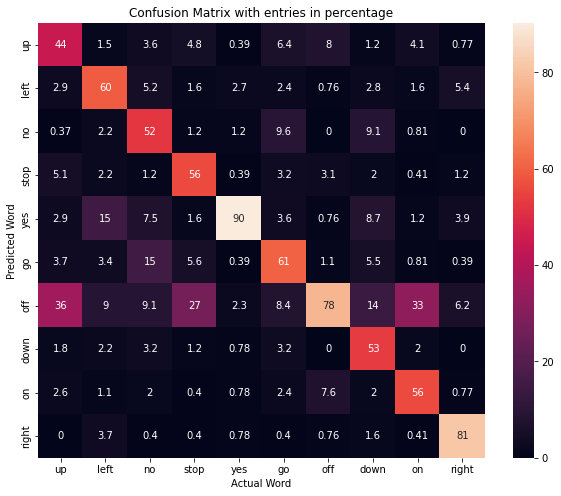

SUMMARY: 
              precision    recall  f1-score   support

          up       0.44      0.61      0.51       199
        left       0.60      0.71      0.65       224
          no       0.52      0.68      0.59       194
        stop       0.56      0.74      0.64       189
         yes       0.90      0.66      0.76       348
          go       0.61      0.62      0.61       245
         off       0.78      0.36      0.49       574
        down       0.53      0.78      0.64       172
          on       0.56      0.73      0.63       189
       right       0.81      0.91      0.86       233

    accuracy                           0.63      2567
   macro avg       0.63      0.68      0.64      2567
weighted avg       0.67      0.63      0.63      2567



In [61]:
from sklearn import metrics
conf_matrix = metrics.confusion_matrix(y_pred, y_actual, labels=test_list)
conf_matrix = 100*conf_matrix/conf_matrix.astype(np.float).sum(axis=0)

import seaborn as sns
plt.figure(figsize = (10,8))
sns.heatmap(conf_matrix, annot=True, xticklabels= test_list,yticklabels= test_list)
plt.title("Confusion Matrix with entries in percentage")
plt.xlabel("Actual Word"); plt.ylabel("Predicted Word"); 
plt.show()

print("SUMMARY: ")
print(metrics.classification_report(y_pred,y_actual,labels=test_list))